In [1]:
# Render plots inline
%matplotlib inline

import sys
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.metrics import roc_curve, roc_auc_score, matthews_corrcoef,auc

pd.set_option('display.mpl_style', 'default')

In [2]:
#Load the data into DataFrame
header1 = ['Binary','GE','E1','E2','E3','E4','E5','E6','E7','E8','E9','E11']
input1 = pd.read_csv("./fiberdock_dataset.txt",delim_whitespace=True,names=header1)
print input1.shape

(8177, 12)


In [3]:
input1.head()

,Binary,GE,E1,E2,E3,E4,E5,E6,E7,E8,E9,E11
0,0,-1.918574,2.352688,-1.256208,0.165204,0.875413,-0.796668,0.578033,-1.552604,0.490196,-1.355415,-2.487593
1,0,0.863482,-0.771219,0.321163,-0.355404,0.519046,-0.584898,0.819217,-0.596050,0.650031,1.081440,0.489979
2,0,-0.308162,-0.881623,0.770948,-0.704080,0.590574,-0.411634,0.514761,-0.201861,-2.592647,-0.834036,0.455020
3,1,0.115547,-0.098220,0.450806,0.109409,0.333842,1.671182,-1.002108,1.207697,0.853287,0.583520,0.338002
4,0,1.128977,-0.697629,-0.008794,0.021314,0.674746,-0.630938,-0.536656,1.224291,0.666598,-1.625399,-1.019776


The input file contains 11 energy terms such as attractive and repulsive van de Waals force, atomic contact energy, partial electrostatics, hydrogen and disulfide bonds, pi-stacking, aliphatic interactions and more for each refined solution produced by FiberDock. The energies were standardized independently for each target complex in order to account for proteins of different lengths forming interfaces of different sizes. Each raw attribute had been converted to the standard score (Z-score).

# Data Cleaning

The data has already been standardized to remove any peculiar behaviour. However, we need to find if any of the data needs to be fixed or removed to be more realistic. 

In [4]:
input1_nan = (input1.isnull().sum()/input1.shape[0]) * 100
input1_nan

Binary    0.000000
GE        0.000000
E1        0.000000
E2        0.000000
E3        0.000000
E4        0.733765
E5        0.648159
E6        0.269047
E7        0.256818
E8        2.837226
E9        0.122294
E11       1.577596
dtype: float64

We have a few NaN in most of the Energy terms. We need to handle the NaN such that we do not penalize a target complex because of absence of a particular interaction energy. So we replace NaN with the median.

In [5]:
input2 = input1.copy()
input2['E4'].fillna(input2.E4.median(),inplace=True)
input2['E5'].fillna(input2.E5.median(),inplace=True)
input2['E6'].fillna(input2.E6.median(),inplace=True)
input2['E7'].fillna(input2.E7.median(),inplace=True)
input2['E8'].fillna(input2.E8.median(),inplace=True)
input2['E9'].fillna(input2.E9.median(),inplace=True)
input2['E11'].fillna(input2.E11.median(),inplace=True)

#print "Medians \nE4 %f \nE5 %f \nE6 %f \nE7 %f \nE8 %f \nE9 %f \nE11 %f \n" %(input2.E4.median(),input2.E5.median(),input2.E5.median(),input2.E7.median(),input2.E8.median(),input2.E9.median(),input2.E11.median())

In [6]:
input2_nan = (input2.isnull().sum()/input2.shape[0]) * 100
input2_nan

Binary    0
GE        0
E1        0
E2        0
E3        0
E4        0
E5        0
E6        0
E7        0
E8        0
E9        0
E11       0
dtype: float64

Making sure that there are no missing values in our data

#Supervised Learning : Random Forest Classifier

In [7]:
def train(X, y):
    rfc = RandomForestClassifier(n_estimators=100)
    return rfc.fit(X, y)

y = input2['Binary'].values
X = input2[['GE','E1','E2','E3','E4','E5','E6','E7','E8','E9','E11']].values

rfc_E11_model = train(X,y)
with open("./rfc_E11.pkl", 'w') as f:
    pickle.dump(rfc_E11_model, f)

#Validation ROC Curve and AUC

In [8]:
total_elem = len(y)

kf = cross_validation.KFold(total_elem, n_folds=5)
print "Results of %d fold cross-validation \n" % len(kf)
print "ACC: Accuracy AUC: Area Under the Curve MCC: Matthews Correlation Coefficient\n"

for k, (train_index, test_index) in enumerate(kf):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = train(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    
    probs = clf.predict_proba(X_test) # probs has 2 columns  [negativer_prob , posisitve_prob]
    pos_probs = probs[:, 1]  # pos probabilities are in the second column
    
    fpr, tpr, thresholds = roc_curve(y_test, pos_probs, pos_label=1)
    roc_auc = auc(fpr, tpr)

    pred = np.where(pos_probs>0.21,1,0)
    mcc = matthews_corrcoef(y_test, pred)
    
    print "Fold %d -> ACC : %0.3f, AUC : %0.3f, MCC : %0.3f" %(k,accuracy,roc_auc,mcc)

Results of 5 fold cross-validation 

ACC: Accuracy AUC: Area Under the Curve MCC: Matthews Correlation Coefficient

Fold 0 -> ACC : 0.925, AUC : 0.960, MCC : 0.728
Fold 1 -> ACC : 0.928, AUC : 0.950, MCC : 0.718
Fold 2 -> ACC : 0.934, AUC : 0.959, MCC : 0.730
Fold 3 -> ACC : 0.935, AUC : 0.955, MCC : 0.686
Fold 4 -> ACC : 0.928, AUC : 0.952, MCC : 0.703


<function matplotlib.pyplot.show>

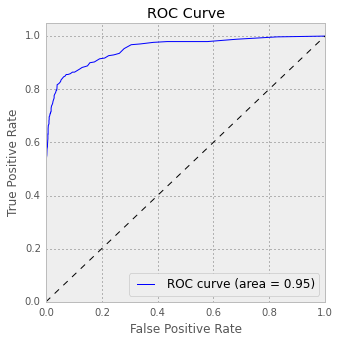

In [11]:
#Plot the ROC Curve 
plt.rcParams['figure.figsize'] = (5, 5)
plt.plot(fpr,tpr,'b', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show

#Feature Importance

Determine and graph the features’ importance of the RFC model.

In [12]:
#feature_list = input2.columns.values[1::]
feature_list = np.array(['glob','aVdW','rVdW','ACE','inside','aElec','rElec','laElec','lrElec','hb','catpiS'])
#Feature Importance
feature_importance = rfc_E11_model.feature_importances_
#Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

In [13]:
#Get a list of sorted indexes of important features
sorted_idx = np.argsort(feature_importance)[::-1]
print "\nFeatures sorted by importance (DESC):\n", feature_list[sorted_idx]


Features sorted by importance (DESC):
['glob' 'catpiS' 'hb' 'rVdW' 'inside' 'rElec' 'lrElec' 'aVdW' 'aElec'
 'laElec' 'ACE']


In [14]:
feature_importance[sorted_idx]

array([ 100.        ,   64.34386291,   63.80558456,   62.23702509,
         38.07900001,   28.79285825,   21.27955356,   19.23826245,
         15.66701089,   15.46892892,   14.70634447])

In [15]:
features_sorted = pd.Series(feature_importance[sorted_idx],index=feature_list[sorted_idx])

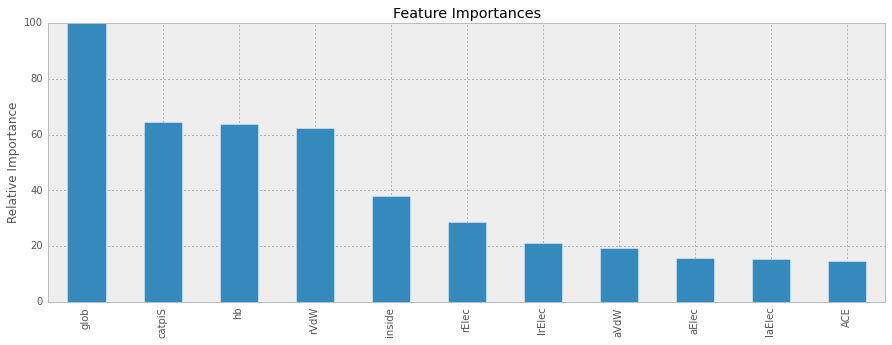

In [16]:
#Plot a bar graph to compare the model's various features' importance. 
plt.rcParams['figure.figsize'] = (15, 5)
features_sorted.plot(kind='bar')
plt.title('Feature Importances')
plt.ylabel('Relative Importance')

#Prediction for a sample case

Load the raw data :

In [17]:
with open ('1amh.ref') as f:
    filelength = len(f.readlines())
noscorelines = filelength - 10

header_energy = ['GE','E1','E2','E3','E4','E5','E6','E7','E8','E9','E11']
raw_data = pd.read_csv('1amh.ref', skiprows=noscorelines, delimiter='|',usecols=(2,3,4,5,6,7,8,9,10,11,13),names=header_energy)

raw_data.head()

,GE,E1,E2,E3,E4,E5,E6,E7,E8,E9,E11
0,-29.06,12.80,-3.00,16.43,0.00,0,0.00,0.00,0.00,-14,-4.5
1,-30.94,10.11,-6.88,21.09,0.00,0,0.00,0.00,-1.83,-4,-3.0
2,-31.52,23.46,-6.12,31.66,0.00,0,-2.65,0.00,0.00,-15,-3.0
3,-24.06,27.38,-3.11,20.91,-18.63,0,-5.68,33.08,0.00,-5,-3.0
4,-17.48,15.59,-1.16,18.70,-45.45,0,-7.68,0.00,0.00,-2,-1.5


Prepare the data. Here we are normalizing it as the M/C model was trained on normalized data.

In [18]:
zscore = lambda x: (x - x.mean()) / x.std(ddof=0)
cols = list(raw_data.columns)
for col in cols:
    col_zscore = col + '_zscore'
    raw_data[col_zscore] = zscore(raw_data[col])

normalized_data=raw_data[['GE_zscore','E1_zscore','E2_zscore','E3_zscore', 'E4_zscore','E5_zscore','E6_zscore','E7_zscore','E8_zscore','E9_zscore','E11_zscore']]
normalized_data.head()

,GE_zscore,E1_zscore,E2_zscore,E3_zscore,E4_zscore,E5_zscore,E6_zscore,E7_zscore,E8_zscore,E9_zscore,E11_zscore
0,-0.786459,-0.260961,-0.121305,-1.304330,0.632441,NaN,0.835326,-0.440888,0.652752,-1.533370,-1.311425
1,-1.091880,-0.681564,-1.389935,-0.146141,0.632441,NaN,0.835326,-0.440888,-1.461471,0.538752,0.045222
2,-1.186105,1.405814,-1.141441,2.480910,0.632441,NaN,0.245658,-0.440888,0.652752,-1.740582,0.045222
3,0.025831,2.018737,-0.157271,-0.190878,-0.695301,NaN,-0.428566,2.818235,0.652752,0.331539,0.045222
4,1.094804,0.175277,0.480314,-0.740147,-2.606736,NaN,-0.873599,-0.440888,0.652752,0.953176,1.401868


Clean the Data - Look for missing values. Here I am replacing the NaN in each coloum with their predetermined medians.

In [19]:
E4_median = 0.242619 
E5_median = -0.358666 
E6_median = -0.358666 
E7_median = -0.206037 
E8_median = 0.383606 
E9_median = -0.134352 
E11_median = 0.191091 
normalized_data['E4_zscore'].fillna(E4_median,inplace=True)
normalized_data['E5_zscore'].fillna(E5_median,inplace=True)
normalized_data['E6_zscore'].fillna(E6_median,inplace=True)
normalized_data['E7_zscore'].fillna(E7_median,inplace=True)
normalized_data['E8_zscore'].fillna(E8_median,inplace=True)
normalized_data['E9_zscore'].fillna(E9_median,inplace=True)
normalized_data['E11_zscore'].fillna(E11_median,inplace=True)

/home/sur/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [20]:
normalized_data.index += 1
normalized_data.head()

,GE_zscore,E1_zscore,E2_zscore,E3_zscore,E4_zscore,E5_zscore,E6_zscore,E7_zscore,E8_zscore,E9_zscore,E11_zscore
1,-0.786459,-0.260961,-0.121305,-1.304330,0.632441,-0.358666,0.835326,-0.440888,0.652752,-1.533370,-1.311425
2,-1.091880,-0.681564,-1.389935,-0.146141,0.632441,-0.358666,0.835326,-0.440888,-1.461471,0.538752,0.045222
3,-1.186105,1.405814,-1.141441,2.480910,0.632441,-0.358666,0.245658,-0.440888,0.652752,-1.740582,0.045222
4,0.025831,2.018737,-0.157271,-0.190878,-0.695301,-0.358666,-0.428566,2.818235,0.652752,0.331539,0.045222
5,1.094804,0.175277,0.480314,-0.740147,-2.606736,-0.358666,-0.873599,-0.440888,0.652752,0.953176,1.401868


Select the top 3 models based on their GE_Zscore. The lower the score, the better the model.

In [21]:
top3modelno = normalized_data.GE_zscore.values.argsort()[:3]

In [22]:
normalized_data.iloc[top3modelno]

,GE_zscore,E1_zscore,E2_zscore,E3_zscore,E4_zscore,E5_zscore,E6_zscore,E7_zscore,E8_zscore,E9_zscore,E11_zscore
3,-1.186105,1.405814,-1.141441,2.480910,0.632441,-0.358666,0.245658,-0.440888,0.652752,-1.740582,0.045222
2,-1.091880,-0.681564,-1.389935,-0.146141,0.632441,-0.358666,0.835326,-0.440888,-1.461471,0.538752,0.045222
7,-1.064262,-0.140566,-1.471677,-0.233129,0.632441,-0.358666,0.835326,-0.440888,-1.392152,0.538752,-1.311425


Load the Model and make a prediction.

In [23]:
X1 = normalized_data.iloc[top3modelno].values
with open('./rfc_E11.pkl', 'r') as f:
    rfc = pickle.load(f)
predictions = rfc.predict_proba(X1)[:,1]

In [24]:
if np.any(predictions >= 0.21) : 
    sys.stdout.write("Biologically Relevant Complex. Predicted FiberDock Model no: ")
    print " ".join(str(p) for p in top3modelno)
else :
    print "This is a Biologically Irrelevant Complex"

Biologically Relevant Complex. Predicted FiberDock Model no: 2 1 6
